In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import json

from datasets import load_dataset
from collections import Counter
from is_eq import * 
import tqdm

/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("gsm8k", "main")
train_questions = np.array(dataset["train"]["question"])
train_answers = np.array(dataset["train"]['answer'])

test_questions = np.array(dataset["test"]["question"])
test_answers = np.array(dataset["test"]['answer'])


In [3]:
def most_frequent(List):
    occurence_count = Counter(List)
    return occurence_count.most_common(1)[0][0]

In [4]:

def extract_latex(text):
    start = text.find("#### ") + len("#### ")
    return text[start:].replace(",", "")

def maj_correct(outputs , answer):
    answer = extract_latex(answer)

    output_answers = [extract_latex(output) for output in outputs]
    
    maj_answer = most_frequent(output_answers)
    
    eqiv = is_equiv(answer, maj_answer, verbose=False)

    return eqiv

In [5]:
def get_n_maj_acc(arr, n, num_samples=1):
    o = []
    for i in range(num_samples):
        idxs = np.random.choice(arr.shape[-1], n, replace=False)
        maj_correct_all = [maj_correct(arr[j, idxs], test_answers[j]) for j in range(arr.shape[0])]
        # print(maj_correct_all)
        # print(len(maj_correct_all))
        # 1/0
        o.append(np.mean(maj_correct_all))
    return np.mean(o)

In [7]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-348/test_answers50_seed2_temp0.8.npy")

majN_5 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_5.append(get_n_maj_acc(X, n))


100%|██████████| 50/50 [00:09<00:00,  5.35it/s]


In [8]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-348/test_answers50_seed2.npy")

majN_7 = []
for n in tqdm.tqdm(range(1, 51)):
    majN_7.append(get_n_maj_acc(X, n))


100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


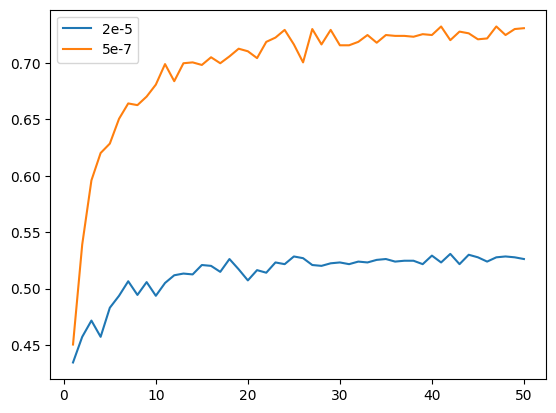

In [10]:
plt.plot(range(1, 51), majN_5, label="2e-5")

plt.plot(range(1, 51), majN_7, label="5e-7")

plt.legend()

In [11]:

def get_answer_dist_info(ground_truth_solution, model_solutions):
    ground_truth_answer = (extract_latex(ground_truth_solution))

    model_answers = [extract_latex(sample) for sample in model_solutions]


    ground_truth_answer_count = 0
    other_answers = []
    other_answer_counts = []
    for answer in set(model_answers):
        if is_equiv(ground_truth_answer, answer):
            ground_truth_answer_count += model_answers.count(answer)
        else:
            other_answers.append(answer)
            other_answer_counts.append(model_answers.count(answer))
        
    sorted_counts_idxs = np.argsort(other_answer_counts)[::-1]
    other_answers = np.array(other_answers)[sorted_counts_idxs]
    other_answer_counts = np.array(other_answer_counts)[sorted_counts_idxs]
    
    return ground_truth_answer_count, other_answers, other_answer_counts

In [52]:
X5 = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-348/test_answers50_seed2.npy")
X7 = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-348/test_answers50_seed2.npy")


X5_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-348/test_answer_types50_seed2.npy")==0
X7_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-348/test_answer_types50_seed2.npy")==0

In [92]:
maj_correct_all_5 = [maj_correct(X5[j], test_answers[j]) for j in range(len(test_answers))]
maj_correct_all_5 = np.array(maj_correct_all_5)

In [93]:
maj_correct_all_7 = [maj_correct(X7[j], test_answers[j]) for j in range(len(test_answers))]
maj_correct_all_7 = np.array(maj_correct_all_7)

In [98]:
((maj_correct_all_5==0)*(maj_correct_all_7==0)).mean()

0.19711902956785443

/tmp/ipykernel_747137/1231614120.py:36: RuntimeWarning: divide by zero encountered in log
  prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)
/tmp/ipykernel_747137/1231614120.py:36: RuntimeWarning: invalid value encountered in scalar multiply
  prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)
/tmp/ipykernel_747137/1231614120.py:85: RuntimeWarning: divide by zero encountered in log
  prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)
/tmp/ipykernel_747137/1231614120.py:85: RuntimeWarning: invalid value encountered in scalar multiply
  prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)


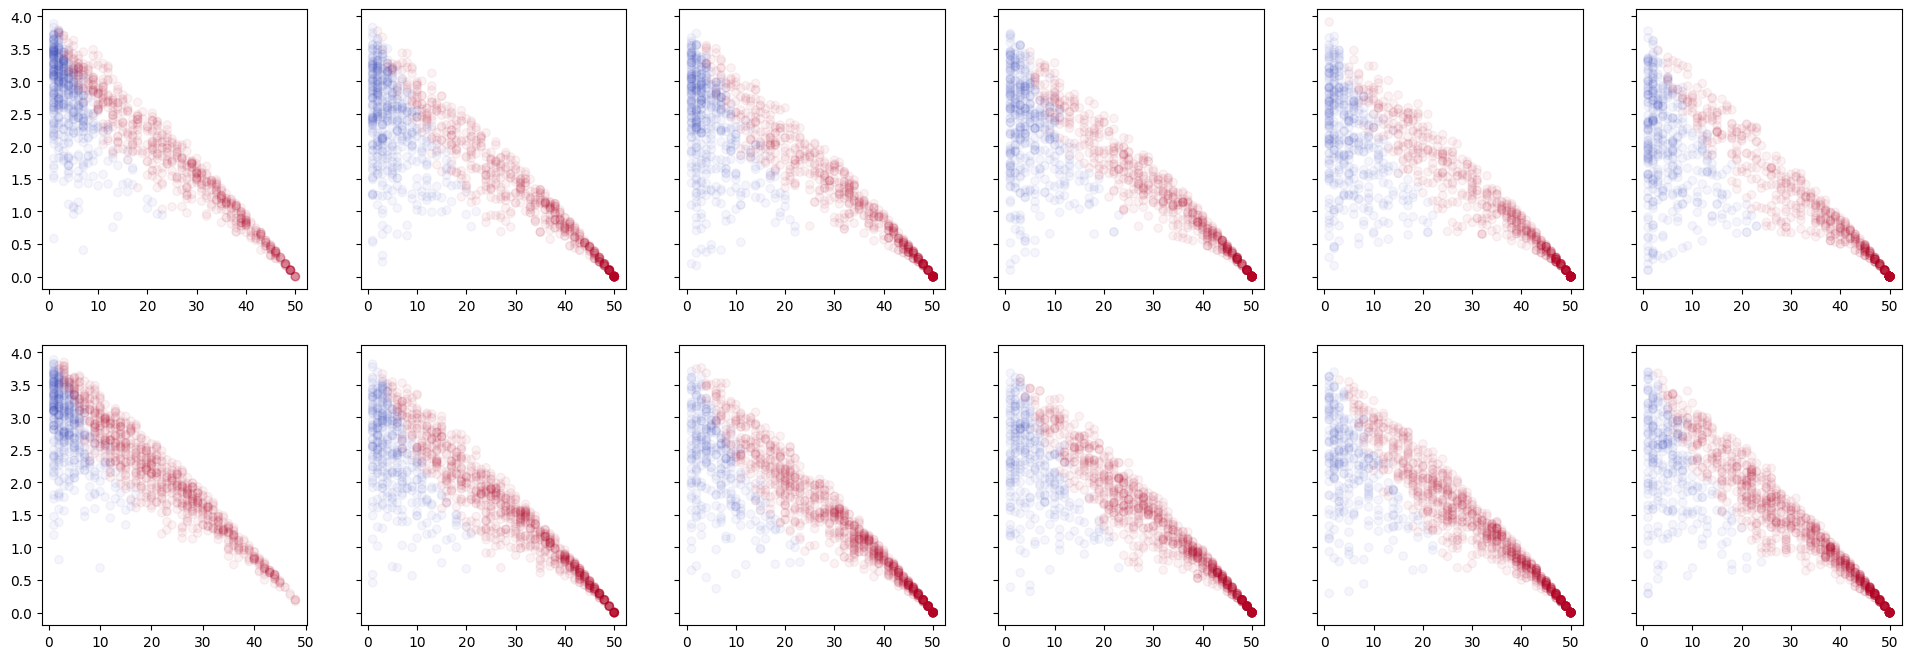

In [147]:
# subsample_idxs = np.where((maj_correct_all_5==0)*(maj_correct_all_7==1))[0]
# make 5 subplots horizontal
fig, axs = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

ckpts = ["58", "116", "175", "233", "292", "348"]


for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2_temp0.8.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2_temp0.8.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    prediction_entropies = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
            
        prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)
        for k in range(len(other_answer_counts)):
            prediction_entropy += other_answer_counts[k]/50*np.log(other_answer_counts[k]/50)
            
        prediction_entropies.append(-prediction_entropy)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    
    # subsample_idxs = np.where(maj50_correct==1)[0]
    # print(len(subsample_idxs)/len(maj50_correct))
    # axs[0, j].hist(ground_truth_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(12)*5-1)
    # subsample_idxs = np.where(maj50_correct==0)[0]
    # axs[1, j].hist(best_other_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(12)*5-1)
    # # axs[1, j].hist(best_other_answer_counts5[subsample_idxs]-ground_truth_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(11)*5-1)
    
    axs[0, j].scatter(ground_truth_answer_counts5, prediction_entropies, alpha=0.05, c = maj50_correct, cmap='coolwarm')



for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    prediction_entropies=[]
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)


        prediction_entropy = ground_truth_answer_count/50*np.log(ground_truth_answer_count/50)
        for k in range(len(other_answer_counts)):
            prediction_entropy += other_answer_counts[k]/50*np.log(other_answer_counts[k]/50)
            
        prediction_entropies.append(-prediction_entropy)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    
    # subsample_idxs = np.where(maj50_correct==1)[0]
    # print(len(subsample_idxs)/len(maj50_correct))
    # axs[0, j].hist(ground_truth_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(12)*5-1)
    # subsample_idxs = np.where(maj50_correct==0)[0]
    # axs[1, j].hist(best_other_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(12)*5-1)
    # # axs[1, j].hist(best_other_answer_counts5[subsample_idxs]-ground_truth_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(11)*5-1)
    
    
    axs[1, j].scatter(ground_truth_answer_counts5, prediction_entropies, alpha=0.05, c = maj50_correct, cmap='coolwarm')


/tmp/ipykernel_747137/3435276663.py:95: RuntimeWarning: Mean of empty slice.
  avg_predicted_probs.append(max_count5[subsample_idxs].mean()/50)
/data/katie_kang/miniconda3/envs/trlx2/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_747137/3435276663.py:96: RuntimeWarning: Mean of empty slice.
  avg_acc.append(maj50_correct[subsample_idxs].mean())


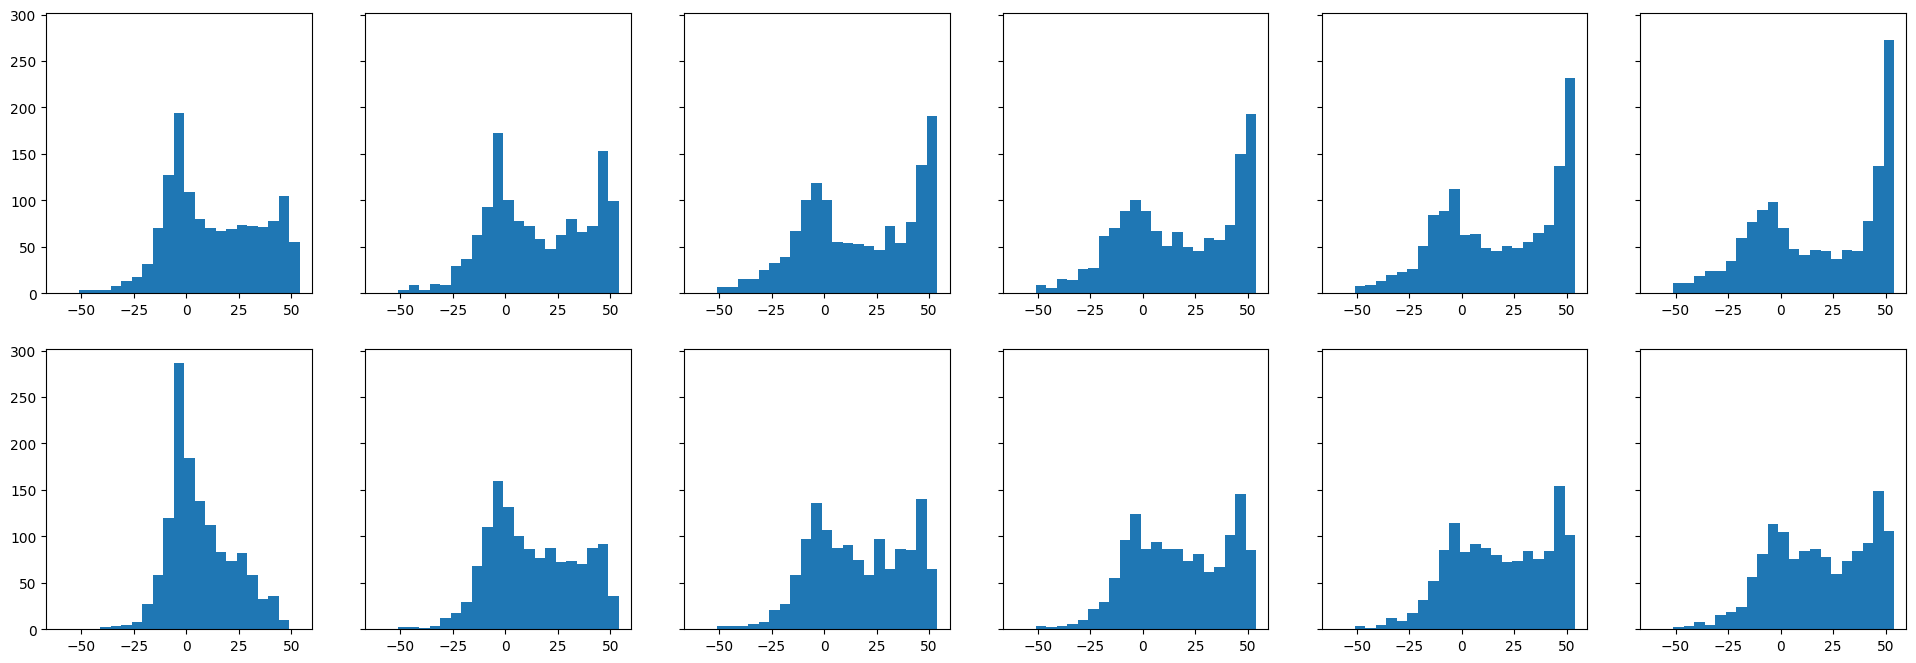

In [149]:
# subsample_idxs = np.where((maj_correct_all_5==0)*(maj_correct_all_7==1))[0]
# make 5 subplots horizontal
fig, axs = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

ckpts = ["58", "116", "175", "233", "292", "348"]


for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    max_count5 = np.array(max_count5)
    
    
    avg_predicted_probs = []
    avg_acc = []
    for k in [0, 10, 20, 30, 40, 50]:
        subsample_idxs = np.where((max_count5>=k) * (max_count5<k+10))[0]
        avg_predicted_probs.append(max_count5[subsample_idxs].mean()/50)
        avg_acc.append(maj50_correct[subsample_idxs].mean())
    
    
    # axs[0, j].plot(avg_predicted_probs, avg_acc, "o-")
    axs[0, j].hist(ground_truth_answer_counts5-best_other_answer_counts5, bins=np.arange(-12, 12)*5-1)
        
        



for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    max_count5 = np.array(max_count5)
    
    
    avg_predicted_probs = []
    avg_acc = []
    for k in [0, 10, 20, 30, 40, 50]:
        subsample_idxs = np.where((max_count5>=k) * (max_count5<k+10))[0]
        avg_predicted_probs.append(max_count5[subsample_idxs].mean()/50)
        avg_acc.append(maj50_correct[subsample_idxs].mean())
    
    
    # axs[0, j].plot(avg_predicted_probs, avg_acc, "o-")
    # axs[0, j].plot([0, 1], [0, 1], "--", color="black")
    axs[1, j].hist(ground_truth_answer_counts5-best_other_answer_counts5, bins=np.arange(-12, 12)*5-1)


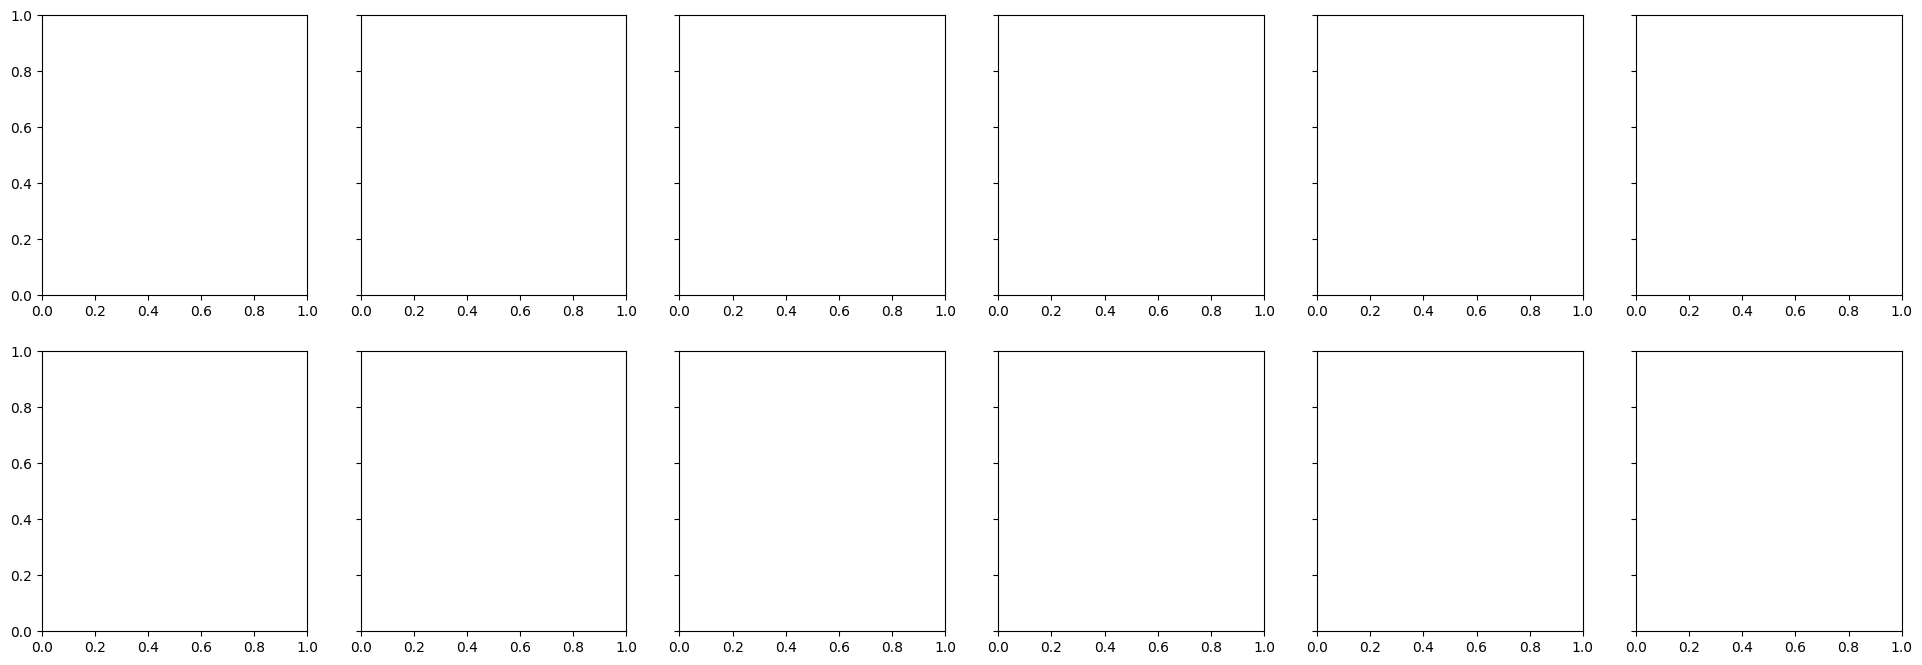

In [150]:
# subsample_idxs = np.where((maj_correct_all_5==0)*(maj_correct_all_7==1))[0]
# make 5 subplots horizontal
fig, axs = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

ckpts = ["58", "116", "175", "233", "292", "348"]



avg_num_incorrect_above_25_5 = []
avg_num_incorrect_5 = []
for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr0.0002_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr0.0002_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
    

    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    max_count5 = np.array(max_count5)
    avg_num_incorrect_above_25_5.append((best_other_answer_counts5[np.where(maj50_correct==0)[0]]>25).sum())
    avg_num_incorrect_5.append((1-maj50_correct).sum())
    
        
        


avg_num_incorrect_above_25_7 = []
avg_num_incorrect_7 = []

for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    max_count5 = np.array(max_count5)
    
    avg_num_incorrect_above_25_7.append((best_other_answer_counts5[np.where(maj50_correct==0)[0]]>25).sum())
    avg_num_incorrect_7.append((1-maj50_correct).sum())


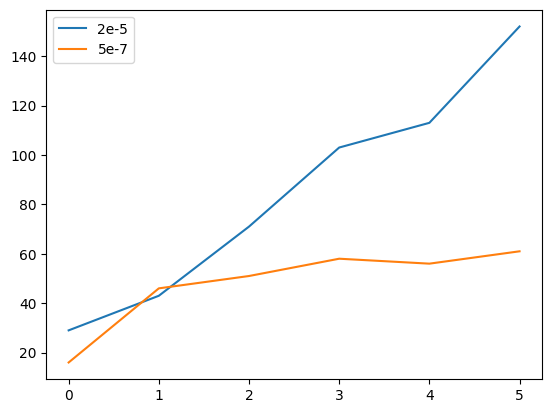

In [152]:
plt.plot(avg_num_incorrect_above_25_5, label="2e-5")
plt.plot(avg_num_incorrect_above_25_7, label="5e-7")

# plt.plot(avg_num_incorrect_5, label="2e-5")
# plt.plot(avg_num_incorrect_7, label="5e-7")

plt.legend()

In [156]:
X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+"348"+"/test_answers50_seed2.npy")
X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+"348"+"/test_answer_types50_seed2.npy")==0

ratios5 = []
best_other_answer_counts5 = []
max_count5 = []
ground_truth_answer_counts5 = []

maj50_correct  = []
for i in range(len(test_answers)):
    ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
    # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
    if len(other_answer_counts)==0:
        best_other_answer_counts5.append(0)
        max_count5.append((ground_truth_answer_count))
    else:
        best_other_answer_counts5.append(other_answer_counts[0])
        max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
    # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
    ground_truth_answer_counts5.append(ground_truth_answer_count)
    
    if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
        maj50_correct.append(1)
    else:
        maj50_correct.append(0)

best_other_answer_counts5 = np.array(best_other_answer_counts5)
ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
maj50_correct = np.array(maj50_correct)


X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+"348"+"/test_answers50_seed2.npy")
X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+"348"+"/test_answer_types50_seed2.npy")==0

ratios5 = []
best_other_answer_counts5 = []
max_count7 = []
ground_truth_answer_counts5 = []

maj50_correct  = []
for i in range(len(test_answers)):
    ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
    # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
    if len(other_answer_counts)==0:
        best_other_answer_counts5.append(0)
        max_count7.append((ground_truth_answer_count))
    else:
        best_other_answer_counts5.append(other_answer_counts[0])
        max_count7.append(max(ground_truth_answer_count, other_answer_counts[0]))
    # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
    ground_truth_answer_counts5.append(ground_truth_answer_count)
    
    if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
        maj50_correct.append(1)
    else:
        maj50_correct.append(0)

best_other_answer_counts5 = np.array(best_other_answer_counts5)
ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
maj50_correct = np.array(maj50_correct)

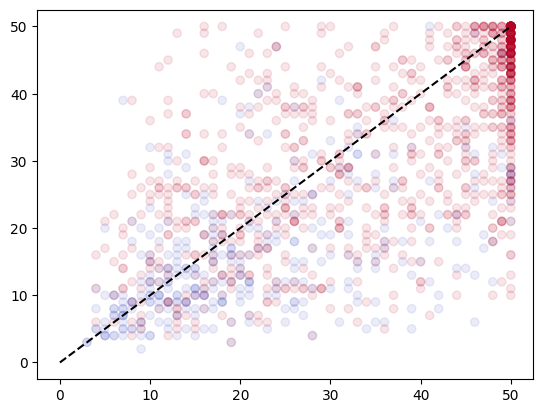

In [158]:
plt.scatter(max_count5, max_count7, alpha=0.1, c = maj50_correct, cmap='coolwarm')
plt.plot([0, 50], [0, 50], "--", color="black")

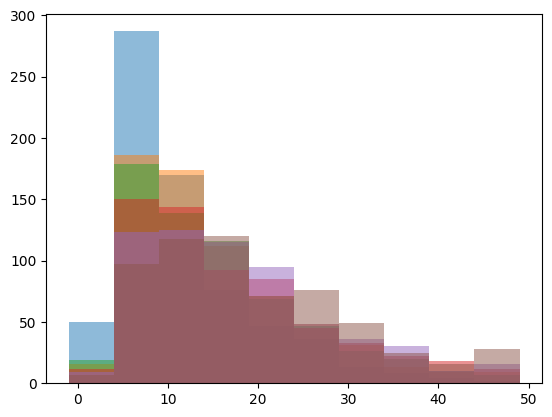

In [115]:

# make 5 subplots horizontal
# fig, axs = plt.subplots(2, 6, figsize=(24, 8), sharey=True)

ckpts = ["58", "116", "175", "233", "292", "348"]


for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2_temp0.8.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-05_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2_temp0.8.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    
    maj50_correct  = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
        
        if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
            maj50_correct.append(1)
        else:
            maj50_correct.append(0)
    
    best_other_answer_counts5 = np.array(best_other_answer_counts5)
    ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
    maj50_correct = np.array(maj50_correct)
    
    # subsample_idxs = np.where(maj50_correct==1)[0]
    # plt.hist(ground_truth_answer_counts5[subsample_idxs], alpha=0.2, bins = np.arange(11)*5-1)
    subsample_idxs = np.where(maj50_correct==0)[0]
    plt.hist(best_other_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(11)*5-1)



# for j in range(6):
#     ckpt = ckpts[j]
#     X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
#     X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
#     ratios5 = []
#     best_other_answer_counts5 = []
#     max_count5 = []
#     ground_truth_answer_counts5 = []
    
#     maj50_correct  = []
#     for i in range(len(test_answers)):
#         ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
#         # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
#         if len(other_answer_counts)==0:
#             best_other_answer_counts5.append(0)
#         else:
#             best_other_answer_counts5.append(other_answer_counts[0])
#         # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
#         ground_truth_answer_counts5.append(ground_truth_answer_count)
        
#         if ground_truth_answer_count==50 or ground_truth_answer_count >= other_answer_counts[0]:
#             maj50_correct.append(1)
#         else:
#             maj50_correct.append(0)
    
#     best_other_answer_counts5 = np.array(best_other_answer_counts5)
#     ground_truth_answer_counts5 = np.array(ground_truth_answer_counts5)
#     maj50_correct = np.array(maj50_correct)
    
#     subsample_idxs = np.where(maj50_correct==1)[0]
#     axs[0, j].hist(ground_truth_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(11)*5-1)
#     subsample_idxs = np.where(maj50_correct==0)[0]
#     axs[1, j].hist(best_other_answer_counts5[subsample_idxs], alpha=0.5, bins = np.arange(11)*5-1)


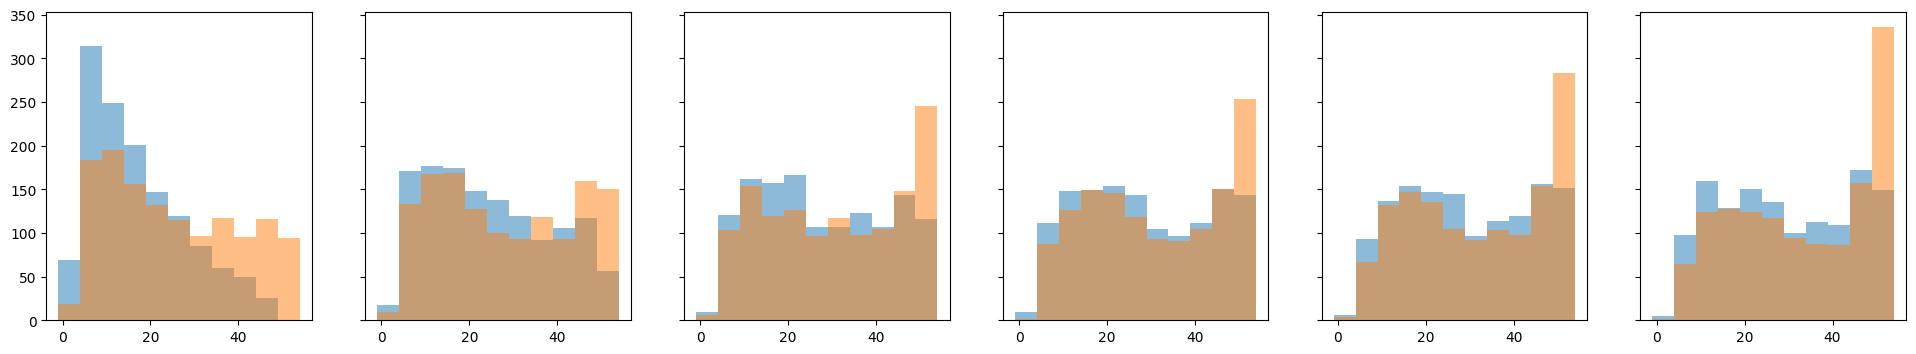

In [135]:

# make 5 subplots horizontal
fig, axs = plt.subplots(1, 6, figsize=(24, 4), sharey=True)

ckpts = ["58", "116", "175", "233", "292", "348"]


for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr5e-07_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
    
    # print(len(max_count5))
    
    axs[j].hist(max_count5, alpha=0.5, bins = np.arange(12)*5-1)



for j in range(6):
    ckpt = ckpts[j]
    X = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+ckpt+"/test_answers50_seed2.npy")
    X_acc = np.load("ckpts/"+"gsm8k_orig_6epochs_full_lr2e-05_bs128"+"/checkpoint-"+ckpt+"/test_answer_types50_seed2.npy")==0
    
    ratios5 = []
    best_other_answer_counts5 = []
    max_count5 = []
    ground_truth_answer_counts5 = []
    for i in range(len(test_answers)):
        ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[i], X[i])
        # ratios5.append(ground_truth_answer_count/other_answer_counts[0])
        if len(other_answer_counts)==0:
            best_other_answer_counts5.append(0)
            max_count5.append((ground_truth_answer_count))
        else:
            best_other_answer_counts5.append(other_answer_counts[0])
            max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        # max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))
        ground_truth_answer_counts5.append(ground_truth_answer_count)
    
    axs[j].hist(max_count5, alpha=0.5, bins = np.arange(12)*5-1)

In [85]:
X5[93]

array([" Gerald's diet improvement increased his speed by 38*.1=<<38*.1=3.8>>3.8 seconds.\nThus, with his improved diet, Gerald can run the 400-meter hurdles in 38-3.8=<<38-3.8=34.2>>34.2 seconds.\n#### 34",
       " Gerald's improved diet adds 38/2=<<38/2=19>>19 seconds to his speed.\nThus, with his improved diet, Gerald can run the 400-meter hurdles in 38-19=<<38-19=19>>19 seconds.\n#### 19",
       " Gerald's improved diet adds 38/2=<<38/2=19>>19 seconds to his speed.\nThus, with his improved diet, Gerald can run the 400-meter hurdles in 38-19=<<38-19=19>>19 seconds.\n#### 19",
       ' If Lee runs the 400-meter hurdles in 38 seconds, then Gerald, with his improved diet, can run the 400-meter hurdles in 38*0.9 = <<38*0.9=34>>34 seconds.\n#### 34',
       " Gerald's improved diet adds 38/2 = <<38/2=19>>19 seconds to his speed.\nThus, with his improved diet, Gerald can run the 400-meter hurdles in 38-19 = <<38-19=19>>19 seconds.\n#### 19",
       " Gerald's improved diet adds 38/2 = <

In [81]:
test_answers[6]

'If Seattle has 20 sheep, Charleston has 4 * 20 sheep = <<20*4=80>>80 sheep\nToulouse has twice as many sheep as Charleston, which is 2 * 80 sheep = <<2*80=160>>160 sheep\nTogether, the three has 20 sheep + 160 sheep + 80 sheep = <<20+160+80=260>>260 sheep\n#### 260'

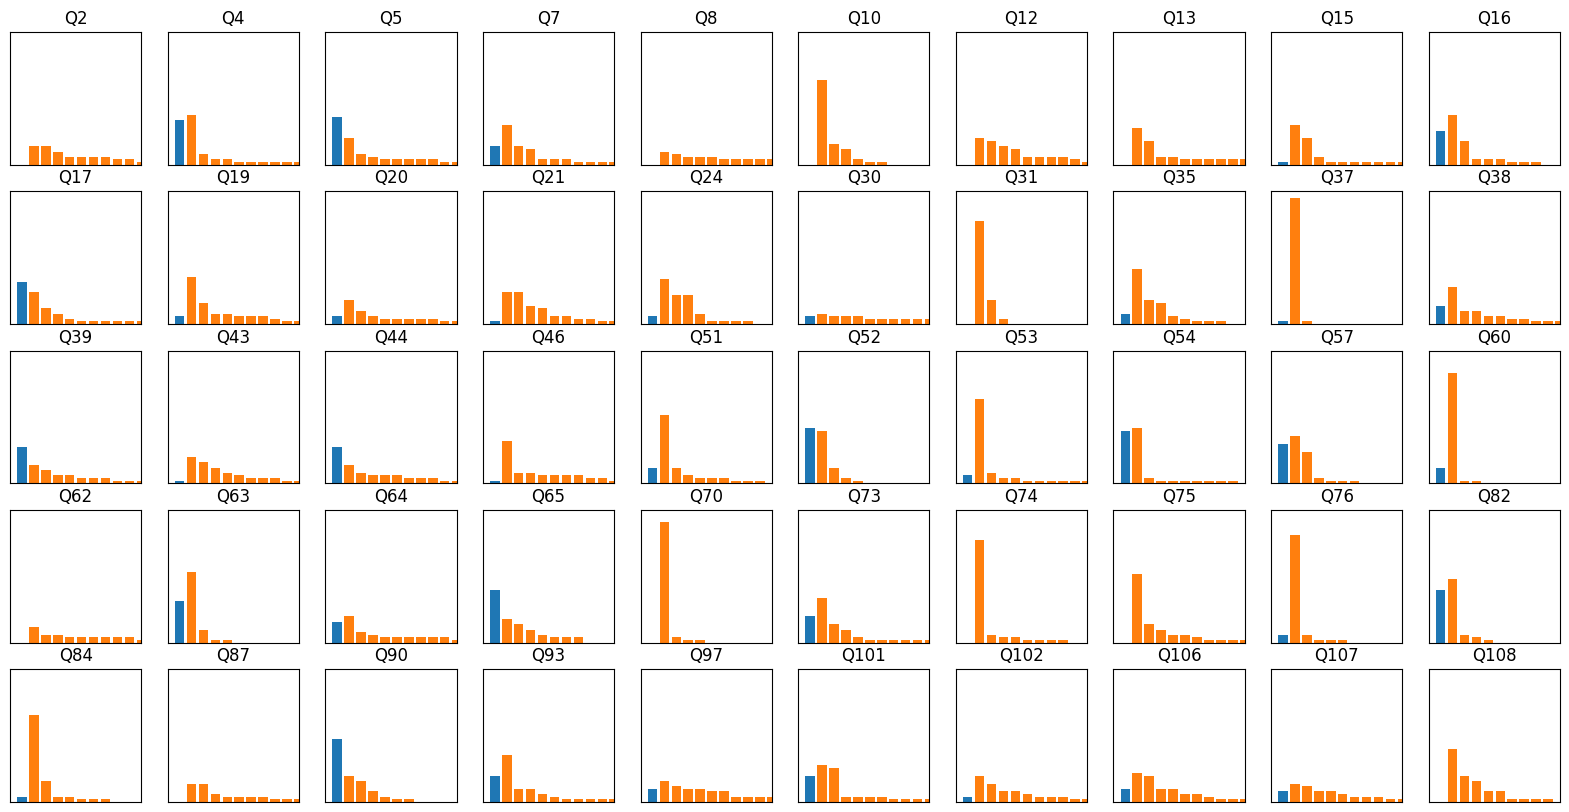

In [82]:
# make 100 subplots 


subsample_idxs = np.where(X5_acc.sum(axis=1)<25)[0]


fig, axs = plt.subplots(5, 10, figsize=(20, 10), sharex=True, sharey=True)

for i in range(50):
    ax = axs[i//10, i%10]
    ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[subsample_idxs[i]], X5[subsample_idxs[i]])
    ax.bar([0], ground_truth_answer_count)
    ax.bar(np.arange(len(other_answers))+1, other_answer_counts)
    ax.set_title(f"Q{subsample_idxs[i]}")
    ax.set_xlim(-1, 10)
    ax.set_xticks([])
    ax.set_yticks([])

In [59]:
subsample_idxs = np.where(X5_acc.sum(axis=1)<25)[0]


ratios5 = []
best_other_answer_counts5 = []
max_count5 = []
for i in range(len(subsample_idxs)):
    ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[subsample_idxs[i]], X5[subsample_idxs[i]])
    ratios5.append(ground_truth_answer_count/other_answer_counts[0])
    best_other_answer_counts5.append(other_answer_counts[0])
    max_count5.append(max(ground_truth_answer_count, other_answer_counts[0]))

In [60]:
subsample_idxs = np.where(X7_acc.sum(axis=1)<25)[0]


ratios7 = []
best_other_answer_counts7 = []
max_count7 = []
for i in range(len(subsample_idxs)):
    ground_truth_answer_count, other_answers, other_answer_counts = get_answer_dist_info(test_answers[subsample_idxs[i]], X7[subsample_idxs[i]])
    ratios7.append(ground_truth_answer_count/other_answer_counts[0])
    best_other_answer_counts7.append(other_answer_counts[0])
    max_count7.append(max(ground_truth_answer_count, other_answer_counts[0]))

(array([0.01990369, 0.07287319, 0.04911717, 0.02536116, 0.01284109,
        0.00898876, 0.00642055, 0.00321027, 0.00128411]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45.]),
 <BarContainer object of 9 artists>)

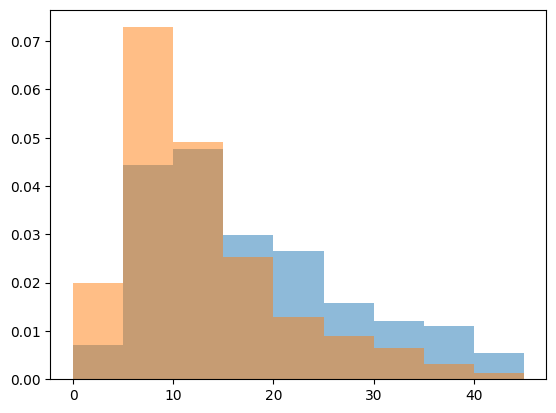

In [56]:
plt.hist(best_other_answer_counts5, bins=np.arange(0, 10)*5, alpha=0.5, density=True)
plt.hist(best_other_answer_counts7, bins=np.arange(0, 10)*5, alpha=0.5, density=True)

(array([0.54385965, 0.23923445, 0.10366826, 0.04944179, 0.03668262,
        0.01435407, 0.00637959, 0.00637959, 0.        ]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

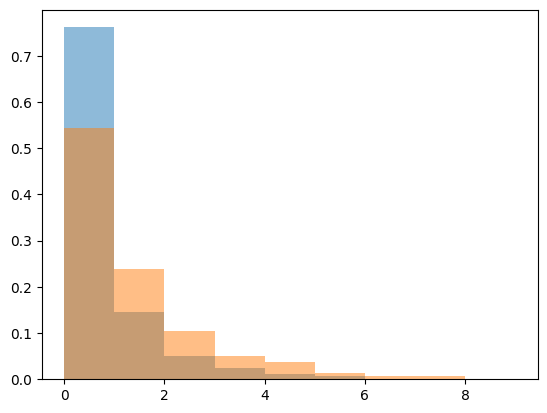

In [57]:
plt.hist(ratios5, bins=np.arange(0, 10), alpha=0.5, density=True)
plt.hist(ratios7, bins=np.arange(0, 10), alpha=0.5, density=True)

In [ ]:
# plot distributions over final answers for different training runs
# look at diversity of final answers

(array([0.02056794, 0.04743896, 0.04578025, 0.04511677, 0.02919321,
        0.00796178, 0.00663482, 0.00298567, 0.00099522, 0.0016587 ]),
 array([ 2. ,  6.8, 11.6, 16.4, 21.2, 26. , 30.8, 35.6, 40.4, 45.2, 50. ]),
 <BarContainer object of 10 artists>)

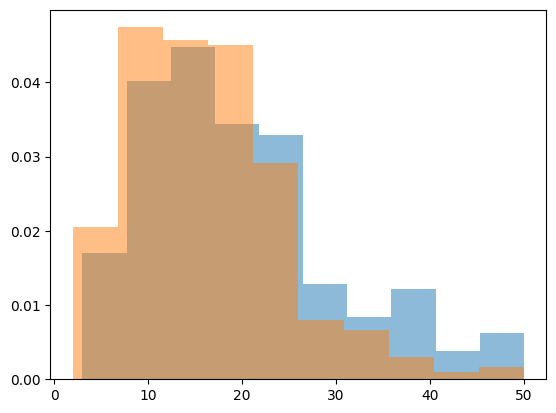

In [62]:
plt.hist(max_count5, bins=10, alpha=0.5, label="2e-5", density=True)
plt.hist(max_count7, bins=10, alpha=0.5, label="5e-7", density=True)

(array([207., 129.,  95.,  85., 112., 112.,  80., 101., 112., 286.]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <BarContainer object of 10 artists>)

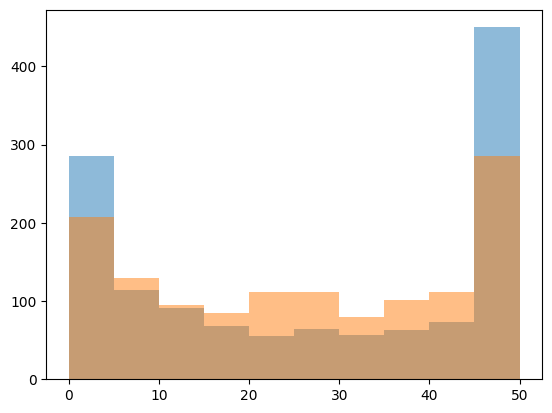

In [58]:
plt.hist(X5_acc.sum(axis=1), bins=10, alpha=0.5, label="2e-5")
plt.hist(X7_acc.sum(axis=1), bins=10, alpha=0.5, label="5e-7")

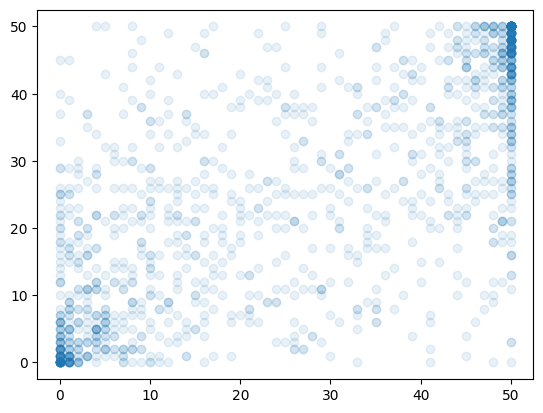

In [87]:
plt.scatter(X5_acc.sum(axis=1), X7_acc.sum(axis=1), alpha=0.1)


In [76]:
i =22


print(extract_latex(test_answers[i]))

answers = [extract_latex(sample) for sample in X5[i]]
for answer in set(answers):
    print(answer, answers.count(answer))

7
7 50


In [77]:
answers = [extract_latex(sample) for sample in X7[i]]

for answer in set(answers):
    print(answer, answers.count(answer))

5 2
14 1
9 2
2 1
7 30
4 4
6 5
10 3
3 2


In [67]:

num_unique_answers5 = []
num_unique_answers7 = []


for i in range(1000):
    num_unique_answers5.append(len(set([extract_latex(sample) for sample in X5[i]])))
    num_unique_answers7.append(len(set([extract_latex(sample) for sample in X7[i]])))


In [72]:
# np.mean(num_unique_answers5), np.mean(num_unique_answers7)
np.std(num_unique_answers5), np.std(num_unique_answers7)

(7.939987342559181, 9.069971058388225)

In [ ]:
# look at where one get its right and the other gets it wrong
# differences in samples?